# This week: PCA! 

Last week, we ran into a fundamental difference between encoding models and pRF-style fits: that with encoding models, you often end up with a great many beta weights for many potentially correlated model features. This week, we will discuss one approach to interpreting many many beta weights, i.e. doing dimensionality reduction with PCA.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys # library for changing system-level settings
import os # library for navigating the operating system, particularly useful for file paths
import json # library to load and save dictionary-like files 
            # NOTE: good for transfer of struct arrays / dicts from matlab->python or vice versa

# pycortex
import cortex as cx
# PCA function
from sklearn.decomposition import PCA
# Z-score function
from scipy.stats import zscore
# Local utility functions
sys.path.append(os.path.abspath('..'))
import utils

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


PCA finds a set of dimension (basis vectors) onto which data can be projected. So, first, let's play with the linear algebra concept of *projection*.

# Projection
First: Projection is multiplication. You should not be afraid of the term. It's another concept with a simple 2D analogy that you have to kind of stretch your brain to think about in multiple dimensions. Here, we will demonstrate projection of one vector onto another in 2D. 

First, we'll define two vectors, a and b.

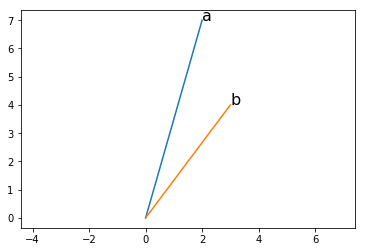

In [2]:
# two 2D vectors
a = np.array([2, 7])
b = np.array([3, 4])
# Plot them!
plt.plot([0, a[0]], [0, a[1]])
plt.plot([0, b[0]], [0, b[1]])
# Label them!
plt.text(a[0], a[1], 'a', fontsize=16)
plt.text(b[0], b[1], 'b', fontsize=16)
# Equal axes make all the following plots nicer
plt.axis('equal');

One preliminary concept is, how long is `a`? and how long is `b`? 

In 2D, this is easy - back to Pythagoras:

### $a^2 + b^2 = c^2$

...so:

### $c = \sqrt{a^2 + b^2}$

This holds in many dimensions, too - so the length of a vector is always:

### $ \displaystyle{L = \sqrt{ \Sigma_{i=0}^nx_i^2}}$

and sure enough, there is a numpy function for this: `np.linalg.norm` computes the length of a vector, or the *vector norm*

In [4]:
length_a = np.linalg.norm(a)
length_b = np.linalg.norm(b)
print(length_a)
print(length_b)

7.280109889280518
5.0


In [5]:
# compute projection of b onto a:
proj_b_to_a = np.sum(b * a) / length_a
print(proj_b_to_a)

4.670259174255427


Another way to do this is to do a matrix multiplication between the two. For that to work, each has to be 2D.

For this simple demo, we will stick with the variables above, but the matrix form of this (`<array>.T.dot(<array>)`) will be useful when we want to do projections of more vectors in more dimensions.

In [6]:
# Reshape a and b to have a (one-unit long) second dimension, so we can transpose them
a_2d = a.reshape(2, 1)
b_2d = b.reshape(2, 1)
# Matrix multiply & divide by norm of a
proj_b_to_a_fancy = a_2d.T.dot(b_2d) / length_a
# Same answer as above...
print(proj_b_to_a_fancy)

[[4.67025917]]


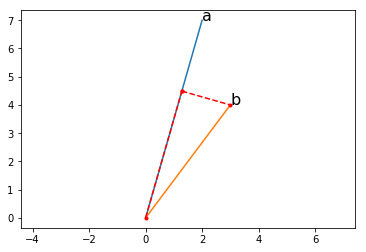

In [7]:
# Plot the vectors again
plt.plot([0, a[0]], [0, a[1]])
plt.plot([0, b[0]], [0, b[1]])
# Label them!
plt.text(a[0], a[1], 'a', fontsize=16)
plt.text(b[0], b[1], 'b', fontsize=16)
# And plot the point at which one projects onto the other
frac_of_a = proj_b_to_a / length_a
c1 = a[0]*frac_of_a
c2 = a[1]*frac_of_a
plt.plot([0, c1], [0, c2], 'r.--')
plt.plot([c1, b[0]], [c2, b[1]], 'r.--')
plt.axis('equal');

You can think of the projection as the "shadow" that b casts on a (when the sun is perpendicular to a)

> Vary the locations of a and b, and see what happens to the projection. As an exercise in plotting, see what happens when you remove the plt.axis('equal') from the cell below

0.5547001962252291


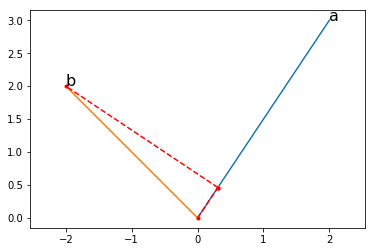

In [23]:
# CHANGE a and b!
a = np.array([2, 3])
b = np.array([-1, 1]) * 2

# Plot the vectors
plt.plot([0, a[0]], [0, a[1]])
plt.plot([0, b[0]], [0, b[1]])
# Label the vectors
plt.text(a[0], a[1], 'a', fontsize=16)
plt.text(b[0], b[1], 'b', fontsize=16)
# Compute projection
length_a = np.linalg.norm(a)
proj_b_to_a = np.sum(b * a) / length_a
print(proj_b_to_a)
# And plot the point at which one projects onto the other
frac_of_a = proj_b_to_a / length_a
c1 = a[0]*frac_of_a
c2 = a[1]*frac_of_a
plt.plot([0, c1], [0, c2], 'r.--')
plt.plot([c1, b[0]], [c2, b[1]], 'r.--')
plt.axis('equal');

> Is the projection of b onto a the same as the distance from b to a? Is it the same as the angle between b and a? 

# Data creation (if you're curious how to create arrays with particular covariance structure)

In [ ]:
n_voxels = 335
n_features = 44
u, s, vt = np.linalg.svd(np.random.randn(n_voxels, n_features))

In [ ]:
n = 10
x = np.linspace(0, 1, n_features)
w = np.exp(-x**2/ (2*0.05**2))
plt.plot(x[:n], w[:n], '.-')

In [ ]:
m, n = n_voxels, n_features
Sd = np.diag(s*w)
Sd = np.pad(Sd,[(0,m-n),(0,0)],mode='constant')
y = u.dot(Sd).dot(vt.T)

In [ ]:
plt.imshow(y, aspect='auto')
plt.xlabel("Features")
plt.ylabel("Voxels")

In [ ]:
np.save('pca_data.npy', y)

# Doing PCA
... with `sklearn` again! The implemetation of this is super simple:

In [34]:
# Load data
y = np.load('pca_data.npy')
n_voxels, n_features = y.shape
n_voxels, n_features

In [39]:
y = np.random.randn(n_voxels, n_features)

Text(0,0.5,'Voxels')

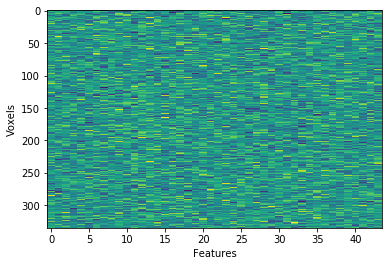

In [40]:
plt.imshow(y, aspect='auto')
plt.xlabel("Features")
plt.ylabel("Voxels")

In [41]:
# Create a PCA fitting object from the PCA object in sklearn (imported above)
pca_fake = PCA(whiten=True)
# Fit the PCA algorithm to the data!
pca_fake.fit(y);
# (technically, doing this on y and the covariance matrix of y is approximately the same thing...)

In [42]:
# Components quantify covariance of FEATURES across VOXELS.
print(pca_fake.components_.shape)
# Each ROW of this is a component!

(44, 44)


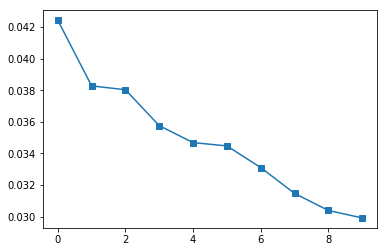

In [43]:
# To see how much variance each component explains, make a scree plot using the explained_variance_ratio_ field
# (as with all objects in sklearn, properties of the fit object with "_" at the end are estimated quantities)
plt.plot(pca_fake.explained_variance_ratio_[:10], 's-')

To show what PCA is doing, let's have a look at the covariance matrix

In [44]:
# Compute the covariance of y across voxels (so the end result is features x features)
y_demean = y - y.mean(0) # subtract off the mean of each column (axis=0 -> mean over columns)
ycov = y_demean.T.dot(y_demean) # dot product
ycov /= (len(y)-1) # normalize by number of elements - 1

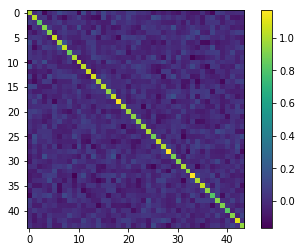

In [45]:
# Show what the covariance across voxels
plt.imshow(ycov)
plt.colorbar()

Next is an example of how to reconstruct the features x features covariance matrix using only ONE principal component.

> Reconstruct the covariance matrix with > 1 principal component! See how close the the result ends up looking to the real covariance matrix above. 

$ (a*pc1)^Tpc1$

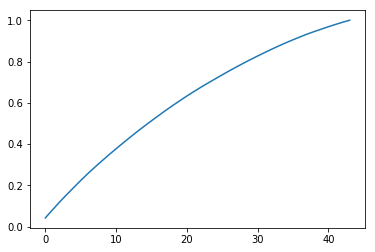

In [50]:
plt.plot(np.cumsum(pca_fake.explained_variance_ratio_))

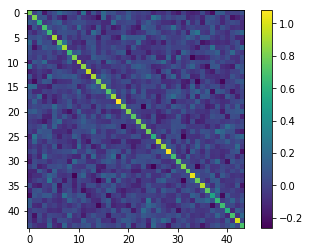

In [49]:
n = 30
pca_cov = (pca_fake.explained_variance_[:n, np.newaxis] * pca_fake.components_[:n]).T.dot(pca_fake.components_[:n])
plt.imshow(pca_cov)
plt.colorbar()

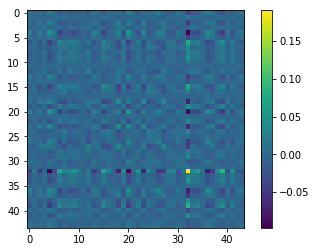

In [37]:
n = 2
pca_cov = (pca_fake.explained_variance_[n:, np.newaxis] * pca_fake.components_[n:]).T.dot(pca_fake.components_[n:])
plt.imshow(pca_cov)
plt.colorbar()

In [38]:
# Compute how much variance this PC explains (this is approximate...)
1 - np.var(ycov-pca_cov) / np.var(ycov, ddof=1)

0.08559282958044856

# With real fMRI data

In [51]:
import h5py

In [52]:
ls /unrshare/LESCROARTSHARE/IntroToEncodingModels/

catloc_design.hdf*                 s01_color_natims_data*
color_natims_features_19cat.hdf*   s01_color_natims_data.hdf*
color_natims_features_19cat.json*  s03_catloc_run01.nii.gz*
color_natims_features_3cat.hdf*    s03_catloc_run02.nii.gz*
color_natims_features_3cat.json*   s03_catloc_run03.nii.gz*
color_natims_features_dst.hdf*     s03_catloc_run04.nii.gz*
color_natims_features_fft.hdf*     s03_catloc_run05.nii.gz*
color_natims_images.hdf*           s03_catloc_run06.nii.gz*
pycortex_store/


In [53]:
# Load Y variables (fMRI data for 1260 estimation images, 126 validation images)
with h5py.File('/unrshare/LESCROARTSHARE/IntroToEncodingModels/s01_color_natims_data.hdf') as hf:
    Y_est = hf['est'].value
    Y_val = hf['val'].value
    mask = hf['mask'].value   
    
# Load X variable (Semantic category features)
with h5py.File('/unrshare/LESCROARTSHARE/IntroToEncodingModels/color_natims_features_19cat.hdf') as hf:
    X_est = hf['est'].value
    X_val = hf['val'].value

In [54]:
print(Y_est.shape)
print(X_est.shape)

(1260, 65242)
(1260, 19)


In [55]:
# Estimate betas!
B = utils.ols(X_est, Y_est)

In [56]:
B.shape

(19, 65242)

> Use the Betas to predict validation data

$ Y = X\beta$

In [57]:
# Answer
y_hat = X_val.dot(B)
r = utils.column_corr(Y_val, y_hat)

/home/mark/Code/UNR_PSY_763/utils/__init__.py:11: RuntimeWarning: Mean of empty slice
  zs = lambda x: (x-np.nanmean(x, axis=0))/np.nanstd(x, axis=0, ddof=dof)
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/mark/Code/UNR_PSY_763/utils/__init__.py:17: RuntimeWarning: invalid value encountered in true_divide
  r = rTmp/n


In [59]:
r = np.nan_to_num(r)

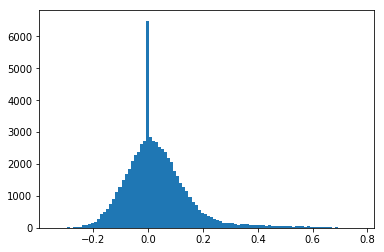

In [61]:
plt.hist(r, bins=100);

### Where did we predict well? 

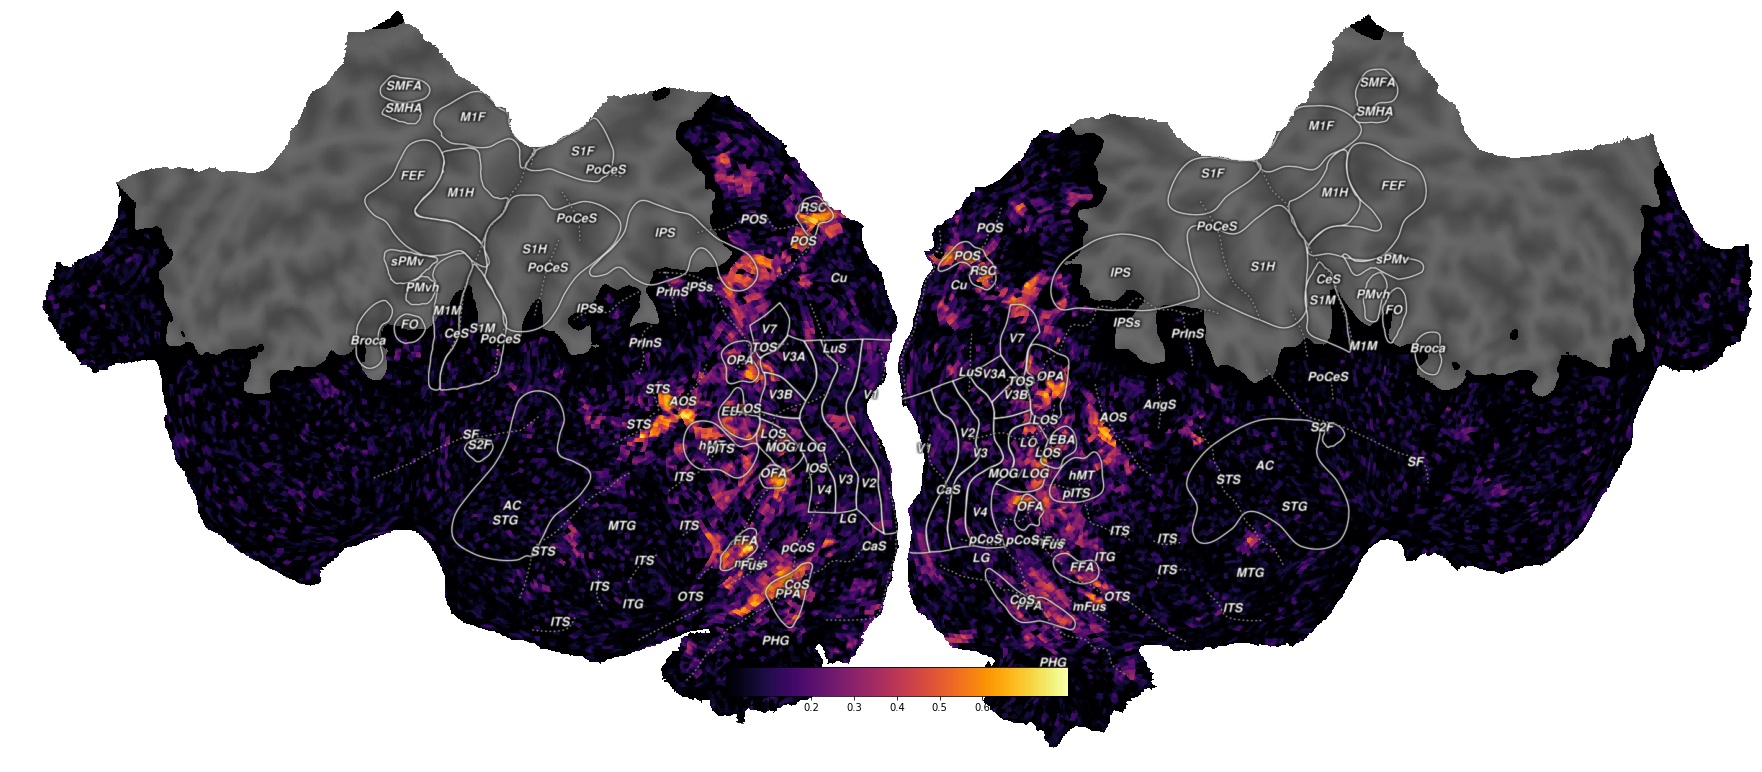

In [62]:
# Create volume for correlation coefficient, visualize across the brain!
subject = 's01'
transform = 'color_natims'
Vr = cx.Volume(r, subject, transform, mask=mask, cmap='inferno', vmin=0, vmax=0.8)
fig = cx.quickflat.make_figure(Vr, with_curvature=True, with_sulci=True)

Yay, we can predict semantic-y / visual category-y areas! Let's do PCA across only those.

In [63]:
B.shape

(19, 65242)

In [65]:
keepers = r > 0.2
B_forpca = B[:, keepers]

In [66]:
B_forpca.shape

(19, 4470)

In [64]:
r.shape

(65242,)

For PCA, we want to perform some voxel selection - let's pick only the voxels that we can predict better than r = 0.2

> DO IT.

In [ ]:
# Answer


Fit PCA for voxels

In [67]:
voxel_pca = PCA(n_components=3)
voxel_pca.fit(B_forpca.T)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Visualize the PC across semantic categories

In [ ]:
pc1 = voxel_pca.components_[0]
pc1_idx = np.argsort(pc1)
plt.plot(pc1[pc1_idx])
plt.axhline(linestyle='--', color='k', lw=0.75)

In [69]:
voxel_pca.transform??

In [68]:
Bt = voxel_pca.transform(np.nan_to_num(B.T))

In [70]:
Bt.shape

(65242, 3)

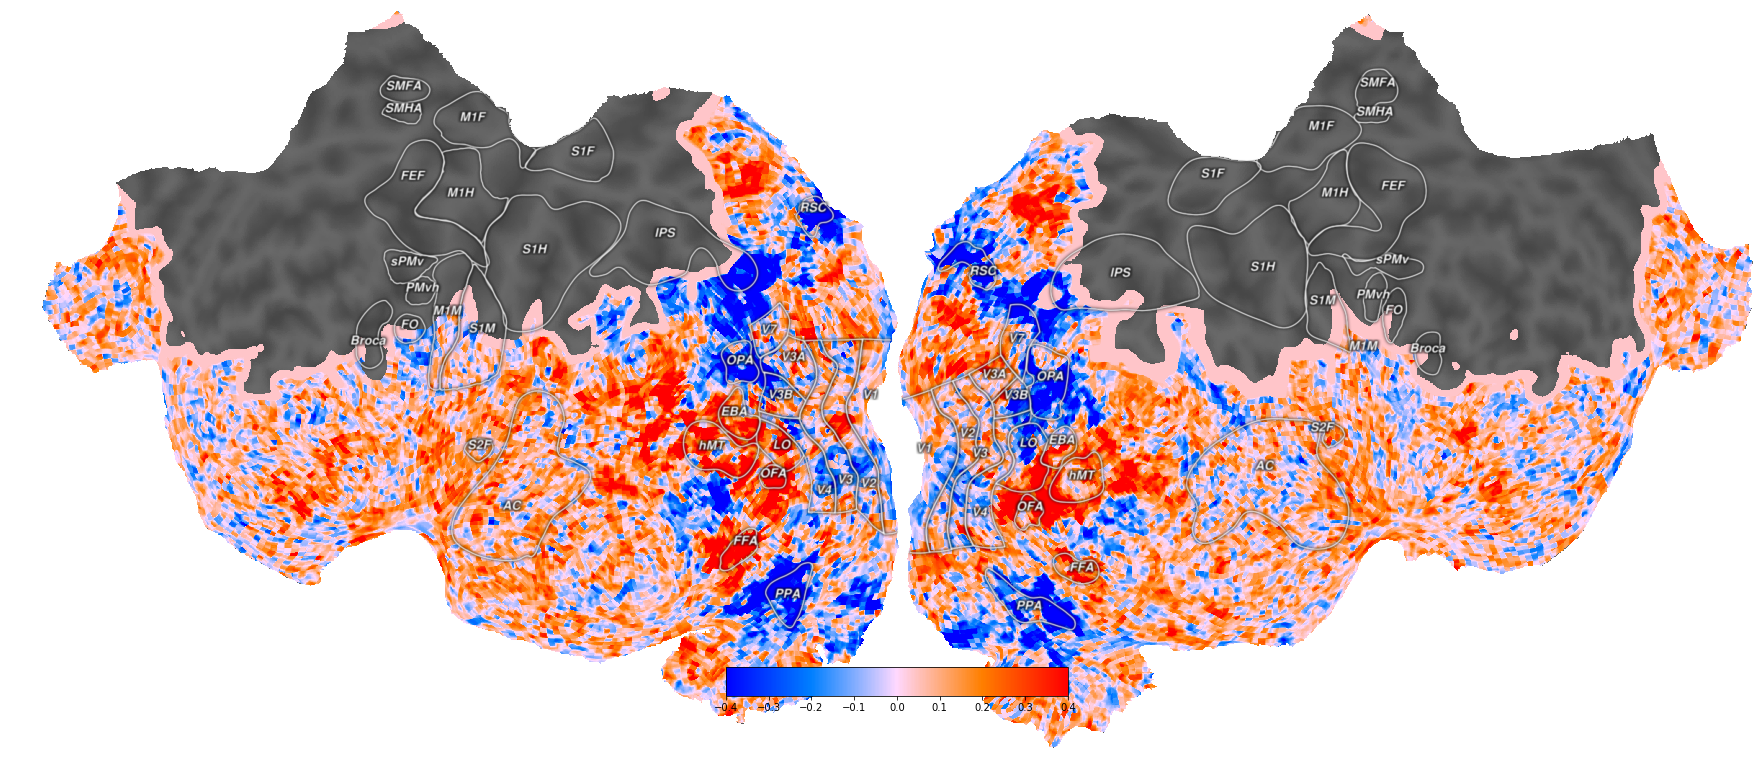

In [71]:
Vpc1 = cx.Volume(Bt[:,0], subject, transform, cmap='BuWtRd', vmin=-0.4, vmax=0.4)
fig = cx.quickflat.make_figure(Vpc1, with_curvature=True)

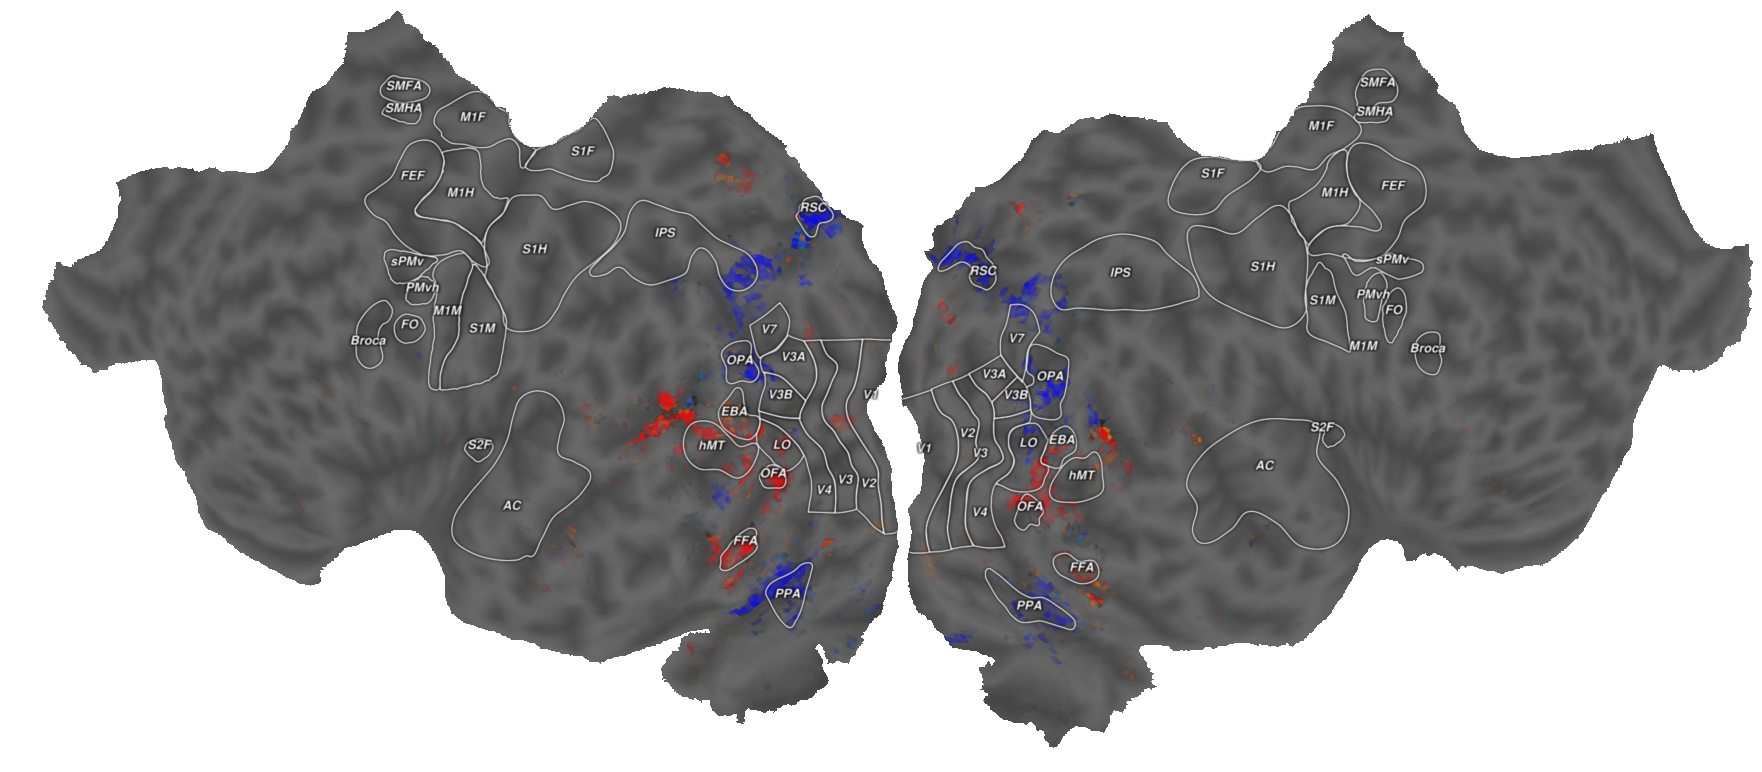

In [72]:
# pycortex advertisement
Vpc1a = cx.Volume2D(Bt[:,0], r, subject, transform, cmap='BuBkRd_alpha_2D', vmin=-0.4, vmax=0.4,
                   vmin2=0.2, vmax2=0.8)
fig = cx.quickflat.make_figure(Vpc1a, with_curvature=True, with_colorbar=False)